This notebook is to apply machine learning using the datasets in Zillow Prize competition: https://www.kaggle.com/c/zillow-prize-1  

## Background
Zillow is the leading real estate and rental marketplace dedicated to empowering consumers with data, inspiration and knowledge around the place they call home, and connecting them with the best local professionals who can help.  
The Zestimate® home valuation is Zillow's estimated market value, computed using a proprietary formula. It is not an appraisal. It is a starting point in determining a home's value. The Zestimate is calculated from public and user-submitted data, taking into account special features, location, and market conditions.   


## Competition
In the public round, two datasets are provided:  
1. train_2016_v2.csv  
The training set has all the transactions from 1/1/2016 to 12/31/2016  
Parcelid: parcel (property) identification code   
logerror: the log error between their Zestimate and the actual sale price   
The log error is defined as log error=log(Zestimate)−log(SalePrice)  
transactiondate: transaction date

2. properties_2016.csv  
a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) with their home features for 2016. Some 2017 new properties don't have any data yet except for their parcelid's. 

In this competition, Zillow is asking participants to predict the log error between their Zestimate and the actual sale price, given all the features of a home. There are 6 time points to predict for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712)

https://www.kaggle.com/c/zillow-prize-1/discussion/33899

## Exploratory data analysis

### Import required modules

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Load data file

In [29]:
df = pd.read_csv('/Users/user/Documents/BentleyCourses/Bentley_Direct_Study/Zillow_house_price/train_2016_v2.csv',parse_dates=['transactiondate'])
df.shape

(90275, 3)

In [30]:
df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [10]:
# check data types
df.get_dtype_counts()

datetime64[ns]    1
float64           1
int64             1
dtype: int64

### How many unique houses are there?

In [11]:
houses = df['parcelid'].unique()
len(houses)

90150

On average, most houses are on sales once.

### What is the time frame?

In [7]:
print(df['transactiondate'].min(), " to ", df['transactiondate'].max())

2016-01-01 00:00:00  to  2016-12-30 00:00:00


### How many transactions for each month?

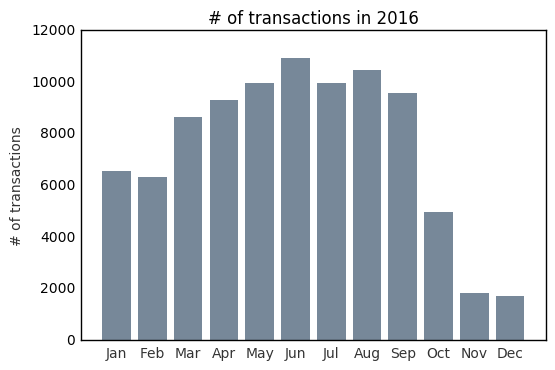

In [8]:
df['transactionmonth'] = df['transactiondate'].dt.month
mth_cnt = df['transactionmonth'].value_counts()

plt.bar(mth_cnt.index,mth_cnt.values,align='center',linewidth=0, color='lightslategrey')
#plt.xlabel('month',alpha=.8)
plt.xlim(0,13)
plt.ylabel('# of transactions',alpha=.8)
plt.title('# of transactions in 2016')
'''
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')         # ticks along the top edge are off
'''
plt.xticks(mth_cnt.index.sort_values(), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],alpha=.8)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
'''
for spine in plt.gca().spines.values():
    spine.set_visible(False)
'''
#plt.axis('off')
plt.show()
# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame

### Let's see how well Zillow predicts by looking at log-error

#### Change the error from logarithmic form to exponential form
log-error = log(Zestimate)−log(SalePrice)
so, eror = Zestimate/SalePrice = 10^(log-error)

In [22]:
df['error'] = np.power(10, df['logerror'])
df.head()

,parcelid,logerror,transactiondate,error
0,11016594,0.0276,2016-01-01,1.065614
1,14366692,-0.1684,2016-01-01,0.678578
2,12098116,-0.0040,2016-01-01,0.990832
3,12643413,0.0218,2016-01-02,1.051478
4,14432541,-0.0050,2016-01-02,0.988553


In [23]:
df['error'].describe()

count    90275.000000
mean         2.847827
std        234.877479
min          0.000025
25%          0.943409
50%          1.013911
75%          1.094460
max      54575.786109
Name: error, dtype: float64

Many errors lie between 0.9 and 1.1, meaning Zestimate does a fairly good work. However, there are significantly large errors that distort the mean and the standard deviation. We will look at boxplots to visualize the errors.

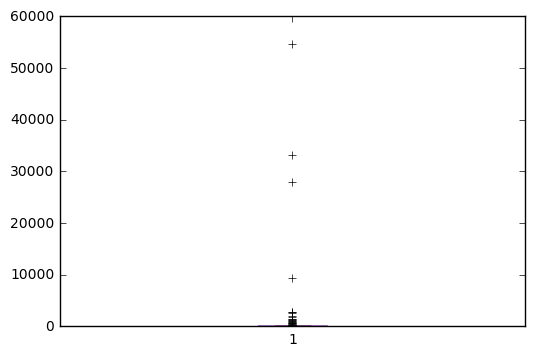

In [40]:
plt.boxplot(df['error'], notch=False)
plt.show()
# https://matplotlib.org/examples/pylab_examples/boxplot_demo.html

Again, the boxplot shows that outliers going up from 10,000 to 60,000. That's why the y-axis has to expand and it's hard to see where most the values lie. So, we will create a boxplot that remove those outliers.

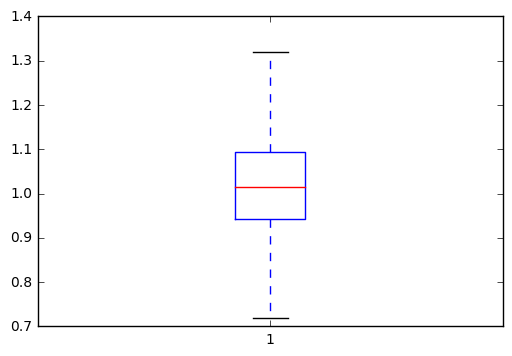

In [45]:
# don't show outlier points
plt.boxplot(df['error'], 0, '')
plt.show()

This boxplot clearly confirms that most of the errors lie between from 0.7 and 1.4

In [13]:
properties = pd.read_csv('/Users/user/Documents/BentleyCourses/Bentley_Direct_Study/Zillow_house_price/properties_2016.csv')

/Users/user/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
properties.shape

(2985217, 58)

In [15]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [16]:
# Data types
properties.get_dtype_counts()

float64    52
int64       1
object      5
dtype: int64

The dataset has a lot of values are missing. Let's check how many missing values for each variable

In [17]:
totalcnt = len(properties)
missing = properties.isnull().sum(axis=0).reset_index()
missing.columns = ['variable','missing_cnt']
missing =missing.drop(missing['variable']=='parcelid')
missing['missing_percent'] = missing['missing_cnt']/totalcnt
missing.sort_values(by='missing_percent',inplace=True, ascending=False)
missing.head()

,variable,missing_cnt,missing_percent
41,storytypeid,2983593,0.999456
3,basementsqft,2983589,0.999455
46,yardbuildingsqft26,2982570,0.999113
49,fireplaceflag,2980054,0.998270
2,architecturalstyletypeid,2979156,0.997970


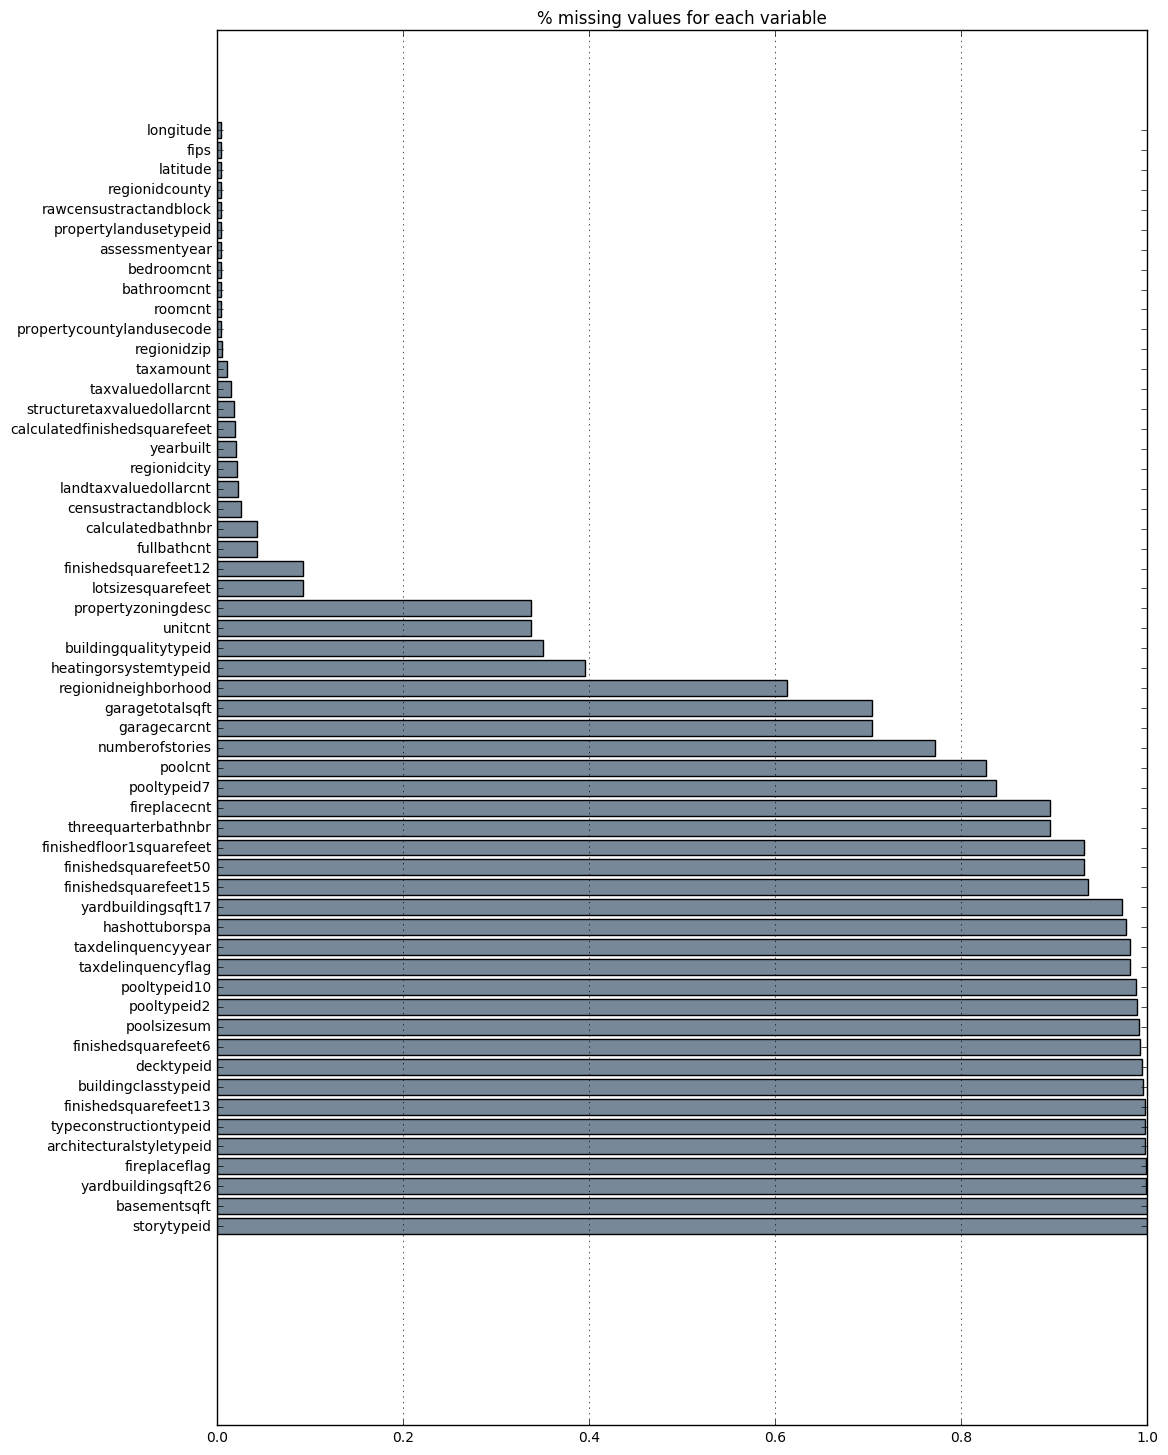

In [18]:
# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12,18))
ind = np.arange(missing.shape[0])
plt.barh(ind, missing['missing_percent'], align='center', color='lightslategrey')
ax.set_yticks(ind)
ax.set_yticklabels(missing['variable'], rotation='horizontal')
plt.title('% missing values for each variable')
ax.xaxis.grid(True)
plt.show()
# https://matplotlib.org/devdocs/gallery/lines_bars_and_markers/barh.html

In [19]:
# create bins to group the missing severity
bins = [0,0.2,0.4,0.6,0.8,0.9,0.95,0.99,1]
group_names = ['<20%','20%-40%','40%-60%','60%-80%','80%-90%','90%-95%','95%-99%','99%-100%']
missing['missing_group']=pd.cut(missing['missing_percent'],bins,labels=group_names)
missing.groupby('missing_group')['variable'].count()

missing_group
<20%        24
20%-40%      4
40%-60%      0
60%-80%      4
80%-90%      4
90%-95%      3
95%-99%      6
99%-100%    11
Name: variable, dtype: int64

Out of 57 variables, 24 variables have less than 20% missing values, 20 variables have greater than 90% missing values.

### Room counts: Bedrooms, Bathrooms, Total rooms

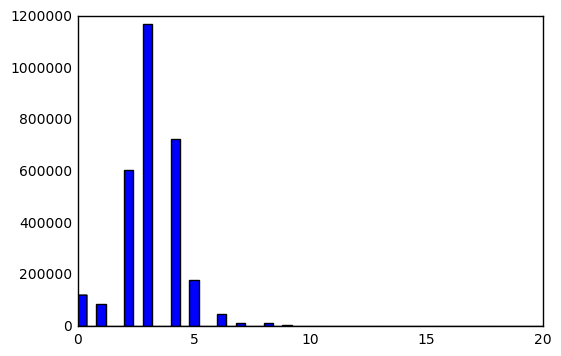

In [25]:
plt.hist(properties['bedroomcnt'].dropna(),bins=50)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
plt.show()

In [34]:
'''
## Combine two datasets
combined = pd.merge(df, properties, on='parcelid', how='left')
combined.shape
combined.head()
'''


"\n## Combine two datasets\ncombined = pd.merge(df, properties, on='parcelid', how='left')\ncombined.shape\ncombined.head()\n"